In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt

# 1. Đọc dữ liệu từ file CSV
data = pd.read_csv('../../data/ai4i2020.csv')

# 2. Chọn các cột đặc trưng và nhãn
features = data.drop(columns=['UDI', 'Product ID', 'Type', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])
labels = data['Machine failure']  # Nhãn bất thường

# 3. Chuẩn hóa dữ liệu
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 4. Chọn dữ liệu bình thường (Machine failure = 0) để huấn luyện
X_train = scaled_features[labels == 0][:8000]  # Huấn luyện với 8000 dòng bình thường
test_data = data.sample(n=5000, random_state=42)  # 5000 dòng ngẫu nhiên cho kiểm tra
X_test = scaler.transform(test_data.drop(columns=['UDI', 'Product ID', 'Type', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']))
y_test = test_data['Machine failure'].values  # Nhãn thực tế cho kiểm tra

# Chuyển đổi sang Tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# 5. Định nghĩa Generator và Discriminator
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, output_dim)
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# 6. Khởi tạo Generator, Discriminator, và optimizer
input_dim = X_train.shape[1]
latent_dim = 40  # Kích thước không gian tiềm ẩn

generator = Generator(latent_dim, input_dim)
discriminator = Discriminator(input_dim)

optimizer_G = optim.Adam(generator.parameters(), lr=0.001)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.001)
loss_function = nn.BCELoss()

# 7. Huấn luyện GAN
epochs = 50
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    for real_data, in train_loader:
        # Huấn luyện Discriminator với dữ liệu thật và giả
        optimizer_D.zero_grad()
        real_labels = torch.ones(real_data.size(0), 1)
        fake_labels = torch.zeros(real_data.size(0), 1)

        outputs = discriminator(real_data)
        real_loss = loss_function(outputs, real_labels)

        noise = torch.randn(real_data.size(0), latent_dim)
        fake_data = generator(noise)
        outputs = discriminator(fake_data)
        fake_loss = loss_function(outputs, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Huấn luyện Generator
        optimizer_G.zero_grad()
        noise = torch.randn(real_data.size(0), latent_dim)
        fake_data = generator(noise)
        outputs = discriminator(fake_data)
        g_loss = loss_function(outputs, real_labels)  # Generator muốn Discriminator nhận nhầm là thật

        g_loss.backward()
        optimizer_G.step()

    print(f'Epoch [{epoch + 1}/{epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')




Epoch [1/50], d_loss: 1.2322, g_loss: 0.7987
Epoch [2/50], d_loss: 1.4511, g_loss: 0.7226
Epoch [3/50], d_loss: 1.2849, g_loss: 0.6998
Epoch [4/50], d_loss: 1.3443, g_loss: 0.6815
Epoch [5/50], d_loss: 1.3006, g_loss: 0.8516
Epoch [6/50], d_loss: 1.4797, g_loss: 0.7293
Epoch [7/50], d_loss: 1.6198, g_loss: 0.6051
Epoch [8/50], d_loss: 1.5951, g_loss: 0.6983
Epoch [9/50], d_loss: 1.3240, g_loss: 0.7391
Epoch [10/50], d_loss: 1.2249, g_loss: 0.8076
Epoch [11/50], d_loss: 1.3162, g_loss: 0.9035
Epoch [12/50], d_loss: 1.3859, g_loss: 0.6892
Epoch [13/50], d_loss: 1.3990, g_loss: 0.7327
Epoch [14/50], d_loss: 1.4369, g_loss: 0.6713
Epoch [15/50], d_loss: 1.4233, g_loss: 0.6852
Epoch [16/50], d_loss: 1.3012, g_loss: 0.8054
Epoch [17/50], d_loss: 1.3227, g_loss: 0.7329
Epoch [18/50], d_loss: 1.3275, g_loss: 0.7787
Epoch [19/50], d_loss: 1.3449, g_loss: 0.7406
Epoch [20/50], d_loss: 1.3154, g_loss: 0.8559
Epoch [21/50], d_loss: 1.3953, g_loss: 0.7010
Epoch [22/50], d_loss: 1.4283, g_loss: 0.73

Ngưỡng phát hiện: 0.5025472223758698
Confusion Matrix:
 [[ 706 4131]
 [  44  119]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.15      0.25      4837
           1       0.03      0.73      0.05       163

    accuracy                           0.17      5000
   macro avg       0.48      0.44      0.15      5000
weighted avg       0.91      0.17      0.25      5000

ROC AUC Score: 0.43800979413544117


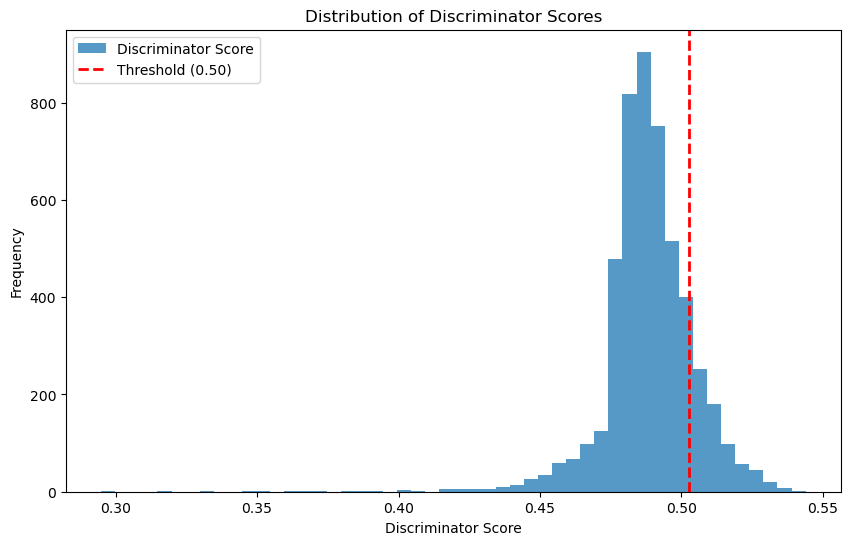

In [20]:
# 8. Dự đoán trên tập kiểm tra bằng Discriminator
with torch.no_grad():
    test_outputs = discriminator(X_test_tensor).numpy().flatten()

# 9. Thiết lập ngưỡng phát hiện bất thường
threshold = np.percentile(test_outputs, 85)
print(f"Ngưỡng phát hiện: {threshold}")

# 10. Dự đoán bất thường
y_pred = (test_outputs < threshold).astype(int)  # Bất thường nếu Discriminator cho điểm thấp

# 11. In Confusion Matrix và Classification Report
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 12. Tính ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc}")

# 13. Vẽ biểu đồ điểm Discriminator và ngưỡng
plt.figure(figsize=(10, 6))
plt.hist(test_outputs, bins=50, alpha=0.75, label='Discriminator Score')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label=f'Threshold ({threshold:.2f})')
plt.xlabel('Discriminator Score')
plt.ylabel('Frequency')
plt.title('Distribution of Discriminator Scores')
plt.legend()
plt.show()